In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from scipy.optimize import minimize

In [24]:
os.chdir('/home/ricky/RNNAE/import_npy')
print('The current working directory is', os.getcwd())

t_all = np.load('Time_all.npy', allow_pickle=True)
m_all = np.load('Magnitude_Abs_all.npy', allow_pickle=True)
m_err_all = np.load('Magnitude_Abs_err_all.npy', allow_pickle=True)
claimedtype_all = np.load('Type_all.npy', allow_pickle=True)
SN_name_all = np.load('SN_name.npy', allow_pickle=True)
print(t_all[0][2])

The current working directory is /home/ricky/RNNAE/import_npy
[ -2.1   8.9  14.9  27.8  30.9  33.9  44.9  48.9  56.8  59.8  62.8  65.8
  67.7  70.8  77.7  86.7  92.8  95.7  97.6 115.7 118.6 121.6]


In [25]:
class GP:

    def __init__(self, t, m, m_err, type, SN_name, filters, filters_EWM = [4.724, 6.202, 7.673], lc_length_prepeak=-50, lc_length_postpeak=135):

        self.t = t
        self.m = m
        self.m_err = m_err

        self.type = type
        self.SN_name = SN_name

        self.filters = filters
        self.filters_EWM = filters_EWM

        self.lc_length_prepeak = lc_length_prepeak
        self.lc_length_postpeak = lc_length_postpeak

        self.x = []
        self.y = []
        self.y_err = []
        self.filters_num = []

        self.data_t = []
        self.data_m = []
        self.data_m_err = []

        self.data = []

        for ii, filter in enumerate(self.filters):
            for jj in range(len(self.t[ii])):

                self.x.append(self.t[ii][jj])
                self.y.append(self.m[ii][jj])
                self.y_err.append(self.m_err[ii][jj])
                self.filters_num.append(self.filters_EWM[ii])

        for ii in range(1 + len(self.filters)*2 + 3):
            self.data.append([])

    def x_GP_pred_generator(self):

        LC_longest_len = 0
        LC_longest_id = 0

        t_min = 0
        t_max = 0

        for ii, filter in enumerate(self.filters):
            if self.t[ii][0] < t_min:
                t_min = self.t[ii][0]
            if self.t[ii][-1] > t_max:
                t_max = self.t[ii][-1]

        '''for ii, filter in enumerate(self.filters):
            if len(self.t[ii]) != 0:
                if (self.t[ii][-1] - self.t[ii][0]) > LC_longest_len:
                    LC_longest_len = self.t[ii][-1] - self.t[ii][0]
                    LC_longest_id = ii'''

        __x = []
        __filters_num = []

        for ii, filter in enumerate(self.filters):
            __t = np.linspace(int(t_min), int(t_max), int(t_max) - int(t_min) + 1)
            for jj in range(len(__t)):
                __x.append(__t[jj])
                __filters_num.append(self.filters_EWM[ii])

        '''for ii, filter in enumerate(self.filters):
            __t = np.linspace(int(self.t[LC_longest_id][0]), int(self.t[LC_longest_id][-1]), int(self.t[LC_longest_id][-1]) - int(self.t[LC_longest_id][0]) + 1)
            for jj in range(len(__t)):
                __x.append(__t[jj])
                __filters_num.append(self.filters_EWM[ii])'''
        
        #print(__x)
        #print(__filters_num)

        x_GP_pred = np.vstack([__x, __filters_num]).T

        return x_GP_pred, t_min, t_max

    def LC_padding(self, GP_pred, GP_var, t_min, t_max):

        lc_len = np.arange(self.lc_length_prepeak, self.lc_length_postpeak, 1)
        #print('lc_len is', lc_len)
        self.data_t = np.linspace(int(t_min), int(t_max), int(t_max) - int(t_min) + 1)
        #self.data_t = np.linspace(int(self.t[LC_longest_id][0]), int(self.t[LC_longest_id][-1]), int(self.t[LC_longest_id][-1]) - int(self.t[LC_longest_id][0]) + 1)
        data_t_len = len(self.data_t)
        padding_point = self.data_t[-1]

        for ii in range(len(self.filters)):
            self.data_m.append([])
            self.data_m_err.append([])
            #print(ii*len(GP_pred)/len(self.filters))
            self.data_m[ii] = GP_pred[int((ii)*len(GP_pred)/len(self.filters)):int((ii+1)*len(GP_pred)/len(self.filters))]
            self.data_m_err[ii] = np.sqrt(GP_var[int((ii)*len(GP_var)/len(self.filters)):int((ii+1)*len(GP_var)/len(self.filters))])
            for jj in range(len(lc_len) - len(self.data_m[ii])):
                self.data_m[ii] = np.append(self.data_m[ii], self.data_m[ii][-1])
                self.data_m_err[ii] = np.append(self.data_m_err[ii], self.data_m_err[ii][-1])

        for ii in range(len(lc_len) - data_t_len):
            self.data_t = np.append(self.data_t, self.data_t[-1] + 1)

        '''print('data_t is', self.data_t, np.array(self.data_t).shape)
        print('data_m is', self.data_m[0], np.array(self.data_m[0]).shape)
        print('data_m_err is', self.data_m_err[0], np.array(self.data_m_err[0]).shape)'''

        self.data[0] = self.data_t
        for ii in range(len(self.filters)):
            self.data[ii+1] = self.data_m[ii]
        for ii in range(len(self.filters)):
            self.data[ii+len(self.filters)+1] = self.data_m_err[ii]
        self.data[-3] = padding_point
        self.data[-2] = self.type
        self.data[-1] = self.SN_name

        return self.data

    def normalization(self):

        y_mean = np.mean(self.y)
        y_range = np.abs(np.max(self.y) - np.min(self.y))

        self.y_err = self.y_err / y_range
        self.y = (self.y - y_mean) / y_range

        return self.y, self.y_err, y_mean, y_range

    def LC_graph(self, y_mean, y_range):

        colors = ['darkcyan', 'limegreen', 'crimson']

        plt.plot(figsize=(16,12))

        for ii, filter in enumerate(self.filters):
            __m = (self.m[ii] - y_mean) / y_range
            __m_err = self.m_err[ii] / y_range
            plt.errorbar(self.t[ii], __m, __m_err, label=filter, color=colors[ii], fmt='.')
            plt.plot(self.data[0], self.data[ii+1], label=filter, color = colors[ii], alpha=0.8)
            plt.fill_between(self.data[0], self.data[ii+1] - self.data[ii+len(self.filters)+1], self.data[ii+1] + self.data[ii+len(self.filters)+1], color=colors[ii], alpha=0.2)

        plt.title('{}, {}'.format(self.SN_name, self.type))
        plt.xlim(-50, 135)
        plt.xlabel('time (day)')
        plt.ylabel('absolute magnitude')
        plt.legend()
        plt.grid()
        plt.gca().invert_yaxis()
        plt.savefig('/home/ricky/RNNAE/GP_graph/{}.pdf'.format(self.SN_name))
        plt.clf()

        return

    def GP_interpolate(self, **kwargs):

        if kwargs['normalization'] == True:
            __, __, y_mean, y_range = GP.normalization(self)

        x_GP = np.vstack([self.x, self.filters_num]).T
        #print('x_GP is', x_GP, np.array(x_GP).shape)

        #x_GP_pred, LC_longest_id = GP.x_GP_pred_generator(self)
        x_GP_pred, t_min, t_max = GP.x_GP_pred_generator(self)
        #print('x_GP_pred is', x_GP_pred, np.array(x_GP_pred).shape)

        kernel = np.var(self.y)*kernels.ExpKernel(metric=[100, 10], ndim=2)
        gp = george.GP(kernel, white_noise=np.log(np.var(self.y)), fit_white_noise=True)

        gp.compute(x_GP, self.y_err)

        def neg_ln_like(p):
            gp.set_parameter_vector(p)
            return -gp.log_likelihood(np.array(self.y))

        def grad_neg_ln_like(p):
            gp.set_parameter_vector(p)
            return -gp.grad_log_likelihood(np.array(self.y))

        try:
            minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like, method='L-BFGS-B')
            gp.recompute()
            GP_pred, GP_var = gp.predict(self.y, x_GP_pred, return_var=True)
        except:
            print('failed to converge')
            return None

        self.data = GP.LC_padding(self, GP_pred, GP_var, t_min, t_max)

        if kwargs['LC_graph'] == True:
            GP.LC_graph(self, y_mean, y_range)

        return self.data
        

0it [00:00, ?it/s]

KeyboardInterrupt: 

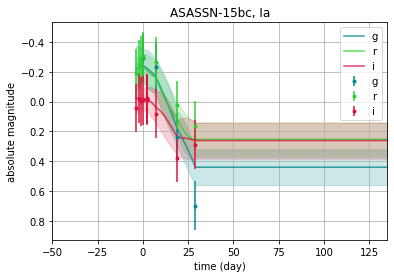

In [29]:

from tqdm.notebook import tqdm
data_all = []
for ii, tqdm in tqdm(enumerate(t_all)):
    data_all.append([])
    data_all[ii] = GP(t_all[ii], m_all[ii], m_err_all[ii], claimedtype_all[ii], SN_name_all[ii], ['g', 'r', 'i']).GP_interpolate(normalization=True, LC_graph=True)
    if data_all[ii] == None:
        print(ii)

np.save('data_GP.npy', np.array(data_all, dtype=object))

In [27]:
print(np.array(data_all[202][0]).shape)

(185,)


In [28]:
print(np.linspace(int(t_all[0][3][0]), int(t_all[0][3][-1]), int(t_all[0][3][-1]) - int(t_all[0][3][0])+1))
print(np.linspace(t_all[0][3][0], t_all[0][3][-1], int(t_all[0][3][-1]) - int(t_all[0][3][0])))

IndexError: index 3 is out of bounds for axis 0 with size 3